## 1. Data Loading

### Goal
To fetch the *Online Retail dataset* and to understand its basic structure and metadata.


In [56]:
pip install ucimlrepo

In [57]:
from ucimlrepo import fetch_ucirepo

# id:352 -> The ID for the Online Retail dataset
online_retail = fetch_ucirepo(id=352)

X = online_retail.data.features # Feature Data (X)

# -- Understanding of current dataset --

# metadata (High Level understanding of the dataset)
print(online_retail.metadata)
# variable information (Detail description of each column)
print(online_retail.variables)

{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

## 2. Data Cleaning

### Goal
To prepare the raw transactional data into a clean, usable format suitable for Recency, Frequency, Monetary (RFM) analysis.

### Importance
Data cleaning is a critical step in any data analysis project. Dirty or incorrect data can lead to misleading insights. For RFM, it's crucial to have accurate sales figures, valid customer IDs, and correct transaction dates.


In [58]:
import pandas as pd
import datetime as dt

# Combine IDs (InvoiceNo, StockNo) with main features (X: Description, Quantity, Invoice Date, UnitPrice, CustomerID, Country)
# To ensure all relevant info is 'together'
df = pd.concat([online_retail.data.ids, X], axis=1)

# Make sure InvoiceDate is a `datetime` object
# Will be used for calculating: Recency
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalSales column
# Will be used for calculating: Monetary
df['TotalSales'] = df['Quantity'] * df['UnitPrice']

# -- Data Cleaning --

# Remove rows where CustomerID is null
# Cannot segment unknown customers
df = df.dropna(subset=['CustomerID'])

# Filter out cancelled transactions (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Further filter out non-positive quantities or prices
# Typically, this means that the data is cancelled so this is the double checkup
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# (Amount of (cleand) data to be handled, Columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, TotalSales)
print(f"Cleaned dataset size: {df.shape}")

Cleaned dataset size: (397884, 9)


## 3. Perform RFM Analysis

### Goal

To calculate the Recency, Frequency, and Monetary values for each unique customer.

In [59]:
import pandas as pd
import datetime as dt

# Snapshot Date:  one day after the last transaction date in the dataset
# == Reference point for calculating: Referency
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group the DataFrame for each customers
rfm_df = df.groupby('CustomerID').agg(
    # Recency: Find difference between snapshot_date & last purchase date
    # REF: (smaller difference, more recent)
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),

    # Frequency: Count number of unique invoice for each customer
    # REF: (higher count, higher frequent)
    Frequency=('InvoiceNo', 'nunique'),

    # Monetary: Sums up the TotalSales for each customer
    # REF: (higher TotalSales, higher spending)
    Monetary=('TotalSales', 'sum')
).reset_index()

# Display some information for the data regarding RFM
print(rfm_df.head())
print(rfm_df.info())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4338 entries, 0 to 4337
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  4338 non-null   float64
 1   Recency     4338 non-null   int64  
 2   Frequency   4338 non-null   int64  
 3   Monetary    4338 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 135.7 KB
None


## 4. Visualize RFM Segments

### Goal
To visually inspect the distribution of RFM values and identify potential customer segments.

## 4.1 Interactive Histogram for Recency

In [60]:
import plotly.express as px

# Create an interactive histogram for 'Recency'
fig_recency = px.histogram(rfm_df, x='Recency', title='Distribution of Recency')
fig_recency.update_layout(xaxis_title='Recency (Days Ago)', yaxis_title='Number of Customers')
fig_recency.show()

### 4.2 Interactive Histogram for Frequency

In [61]:
# Create an interactive histogram for 'Frequency'
fig_frequency = px.histogram(rfm_df, x='Frequency', title='Distribution of Frequency')
fig_frequency.update_layout(xaxis_title='Frequency (Number of Purchases)', yaxis_title='Number of Customers')
fig_frequency.show()

### 4.3 Interactive Histogram for Monetary

In [62]:
# Create an interactive histogram for 'Monetary'
fig_monetary = px.histogram(rfm_df, x='Monetary', title='Distribution of Monetary Value')
fig_monetary.update_layout(xaxis_title='Monetary (Total Spend)', yaxis_title='Number of Customers')
fig_monetary.show()

### 4.4 Scatter plot for Frequency vs Monetary

In [63]:
# Create an interactive scatter plot for 'Frequency' vs. 'Monetary'
fig_scatter = px.scatter(rfm_df, x='Frequency', y='Monetary', title='Frequency vs. Monetary Value')
fig_scatter.update_layout(xaxis_title='Frequency (Number of Purchases)', yaxis_title='Monetary (Total Spend)')
fig_scatter.show()

## 5. RFM Customer Segmentation (Clustering)

### Goal
To segment customers into distinct groups based on their RFM scores using K-Means clustering. This will allow for a more nuanced understanding of customer behavior and provide a basis for targeted marketing strategies.

### Importance
Clustering helps in identifying natural groupings within the customer base. By segmenting customers, businesses can tailor their marketing efforts, product recommendations, and retention strategies to specific customer needs and behaviors, leading to improved customer satisfaction and increased profitability.

### 5.1 Standardize RFM Values

**Reasoning:** RFM values (Recency, Frequency, Monetary) often operate on different scales.

 > For instance, monetary values can be much larger than recency days.


 Clustering algorithms, especially distance-based ones like K-Means, are sensitive to the scale of the features. **Standardizing** these values ensures that each feature contributes equally to the distance calculations, preventing features with larger values from dominating the clustering process.

In [64]:
from sklearn.preprocessing import StandardScaler

# Remove CustomerID (for now) as it's an identifier, not a feature for clustering
rfm_features = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Initialize StandardScaler
scaler = StandardScaler()

# Fit & transform the RFM features
rfm_scaled = scaler.fit_transform(rfm_features)

# Convert scaled data back to a DataFrame for better readability
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_features.columns)

# The result of standardizing the RFM Data scaling
print("Scaled RFM Data (first 5 rows):")
print(rfm_scaled_df.head())
print(rfm_scaled_df.describe())

Scaled RFM Data (first 5 rows):
    Recency  Frequency  Monetary
0  2.334574  -0.425097  8.358668
1 -0.905340   0.354417  0.250966
2 -0.175360  -0.035340 -0.028596
3 -0.735345  -0.425097 -0.033012
4  2.174578  -0.425097 -0.191347
            Recency     Frequency      Monetary
count  4.338000e+03  4.338000e+03  4.338000e+03
mean   2.702618e-17  1.801745e-17  1.801745e-17
std    1.000115e+00  1.000115e+00  1.000115e+00
min   -9.153401e-01 -4.250965e-01 -2.281344e-01
25%   -7.453445e-01 -4.250965e-01 -1.943495e-01
50%   -4.153533e-01 -2.951776e-01 -1.535104e-01
75%    4.946227e-01  9.457903e-02 -4.367134e-02
max    2.814561e+00  2.659803e+01  3.094634e+01


### 5.2 Determine Optimal Number of Clusters (Elbow Method)

**Reasoning:** The Elbow method is a heuristic used to find the optimal number of clusters for a K-Means algorithm.

> It plots the within-cluster sum of squares (WCSS) against the number of clusters (K).

The '*elbow*' point on the plot, where the rate *decreases* in WCSS significantly shows a slow down, suggests a good balance between minimizing distortion and having a reasonable number of clusters.

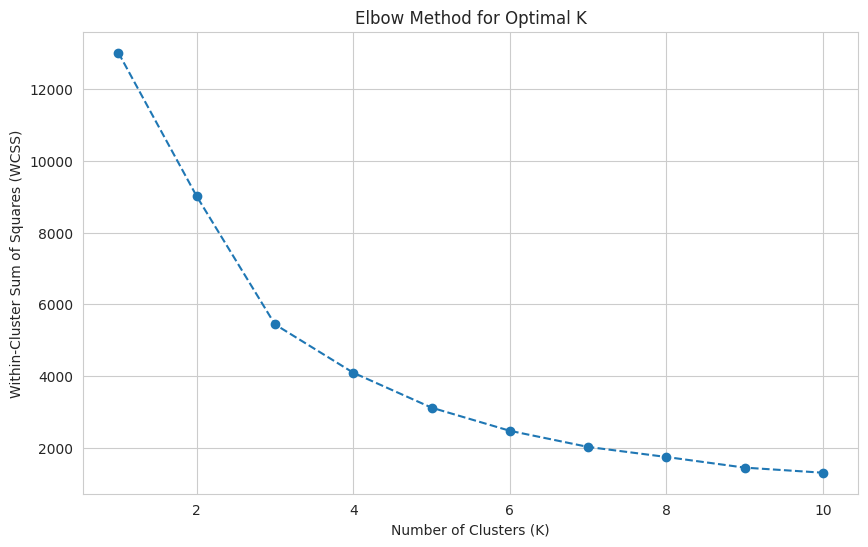

In [65]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
# Try K from 1 to 10
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10) # n_init to suppress warning
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

### 5.3 Perform K-Means Clustering and Add Cluster Labels

**Reasoning:** Based on the Elbow method (or a reasonable choice, e.g., 4 clusters for common RFM segments), we'll apply K-Means clustering to the standardized data. The resulting cluster labels will then be added to our original `rfm_df` to categorize each customer into their respective segment.

In [66]:
from sklearn.cluster import KMeans

# Based on the Elbow graph, 4 clusters would be the sweet spot
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(f"RFM DataFrame with {n_clusters} clusters (first 5 rows):")
print(rfm_df.head())

# Cluster Distribution
print(rfm_df['Cluster'].value_counts())

RFM DataFrame with 4 clusters (first 5 rows):
   CustomerID  Recency  Frequency  Monetary  Cluster
0     12346.0      326          1  77183.60        3
1     12347.0        2          7   4310.00        0
2     12348.0       75          4   1797.24        0
3     12349.0       19          1   1757.55        0
4     12350.0      310          1    334.40        1
Cluster
0    3054
1    1067
3     204
2      13
Name: count, dtype: int64


### 5.4 3D Scatter Plot of Customer Clusters based on RFM Scores

**Reasoning:** A 3D scatter plot allows us to visualize the customer clusters in the three-dimensional space defined by Recency, Frequency, and Monetary values. This interactive visualization provides a powerful way to observe the separation and characteristics of each customer segment, making the RFM analysis more intuitive and impactful for a dashboard.

In [67]:
import plotly.express as px

fig_3d_scatter = px.scatter_3d(rfm_df,
                               x='Recency',
                               y='Frequency',
                               z='Monetary',
                               color='Cluster',
                               title='3D RFM Customer Clusters',
                               hover_data=['CustomerID'])
fig_3d_scatter.update_layout(scene = dict(
                    xaxis_title='Recency',
                    yaxis_title='Frequency',
                    zaxis_title='Monetary'))
fig_3d_scatter.show()

### 5.5 Find the mean of each cluster

Reasoning: Get the middle ground for each cluster. Important to set a clear differentiation between which can leada to easier business strategy planning and customer classification.

In [68]:
cluster_profiles = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

print("Mean RFM values for each cluster:")
print(cluster_profiles)

Mean RFM values for each cluster:
            Recency  Frequency       Monetary
Cluster                                      
0         43.702685   3.682711    1359.049284
1        248.075914   1.552015     480.617480
2          7.384615  82.538462  127338.313846
3         15.500000  22.333333   12709.090490


## 6. Summary of RFM Segments and Insights

### 6.1. What is RFM

The customer segments were identified using Recency, Frequency, and Monetary (RFM) analysis. These values indicate customer behavior based on their recent activity, purchase frequency, and total spending.


### 6.2. Key insights
*   **Customer Distribution by Recency:** Visualizing how recently customers made a purchase helps identify new customers versus dormant ones.
*   **Customer Distribution by Frequency:** Understanding how often customers purchase can highlight loyal, repeat buyers versus one-time purchasers.
*   **Customer Distribution by Monetary Value:** Analyzing spending habits identifies high-value customers versus those with lower spend.
*   **Frequency vs. Monetary Relationship:** A scatter plot can reveal segments of customers who buy frequently and spend a lot (e.g., "Champions") versus those who buy frequently but spend less (e.g., "Frequent Bargain Hunters").

### 6.3. Why the interactive Plotly visualizations is important?

The interactive 3D Plotly visualization enhances insights by providing a clear visual confirmation of the identified customer segments. It distinctly shows each cluster's position in the Recency, Frequency, and Monetary space, allowing for easy identification of "Champions" (*low Recency, high Frequency/Monetary*) and "At-Risk" customers (*high Recency, low Frequency/Monetary*). The ability to rotate and zoom into the plot offers a deeper, more intuitive understanding of segment separation and density, making it an invaluable tool for an e-commerce dashboard.

### 6.4. Data Analysis Key Findings

**Four distinct customer segments** were identified based on their
average Recency, Frequency, and Monetary values.


Based on the `cluster_profiles`:

*   **Cluster 0 (Avg. Recency: 43.7, Avg. Frequency: 3.68, Avg. Monetary: 1359.05):**
    *   **Description:** These customers have a moderate recency, frequency, and monetary value. They are fairly active but not among the top spenders or most frequent buyers. They could be **"Regular Customers"** or **"Potential Loyalists"**.
    *   **Marketing Strategy:** Encourage increased frequency and monetary value. Offer loyalty programs, personalized recommendations based on past purchases, and exclusive discounts to motivate them to move into higher-value segments.

*   **Cluster 1 (Avg. Recency: 248.08, Avg. Frequency: 1.55, Avg. Monetary: 480.62):**
    *   **Description:** These customers have high recency (meaning they haven't purchased recently), low frequency, and low monetary value. They are likely **"At-Risk Customers"** or **"Lost Customers"**.
    *   **Marketing Strategy:** Implement win-back campaigns with aggressive discounts, re-engagement emails, or special offers on products they previously showed interest in. Try to understand reasons for churn if possible through surveys.

*   **Cluster 2 (Avg. Recency: 7.38, Avg. Frequency: 82.54, Avg. Monetary: 127338.31):**
    *   **Description:** This cluster represents customers with very low recency (purchased very recently), extremely high frequency, and exceptionally high monetary value. These are clearly the **"Champions"** or **"Best Customers"**.
    *   **Marketing Strategy:** Reward them with VIP treatment, exclusive access to new products, early sales previews, and personalized communication. Focus on retention and encouraging word-of-mouth referrals. Solicit feedback to ensure continued satisfaction.

*   **Cluster 3 (Avg. Recency: 15.5, Avg. Frequency: 22.33, Avg. Monetary: 12709.09):**
    *   **Description:** These customers have low recency, high frequency, and high monetary value, though not as extreme as Cluster 2. They are likely **"Loyal Customers"** or **"High-Value Engaged"**.
    *   **Marketing Strategy:** Maintain engagement through personalized communication, exclusive content, and loyalty programs. Cross-sell and up-sell relevant products. Encourage them to become advocates for the brand.


### 6.5. Insights or Next Steps
*   Leverage the interactive 3D Plotly visualization in an e-commerce dashboard to allow stakeholders to intuitively explore customer segments and their behavioral patterns, facilitating quicker decision-making for targeted campaigns.
*   Continuously monitor the RFM profiles of these clusters over time to detect shifts in customer behavior, validate the effectiveness of marketing strategies, and adjust segment definitions or strategies as needed.
